In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix

In [4]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR100(root='../../../notebooks/Data/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='../../../notebooks/Data/', train=False, download=True, transform=transform)

print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ../../../notebooks/Data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ../../../notebooks/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()


torch.Size([3, 32, 32])


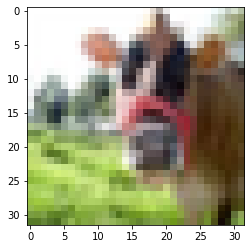

In [37]:
# Single image from data set.
image = None
for image, label in train_data:
    break

print(image.shape)
plt.imshow(np.transpose(image.numpy(), axes=(1, 2, 0)))

tensor([12, 88, 52, 42, 49,  1,  6, 41, 99, 26])


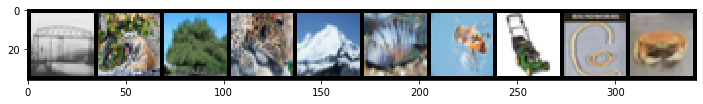

In [32]:
# Load batches print.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

images, labels = None, None
for images, labels in train_loader:
    break

img = make_grid(images, nrow=10)
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(img.numpy(), axes=(1, 2, 0)))
print(labels)

In [52]:
LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

len(LABELS_LIST)

100

In [ ]:
# Model declaration.
class ConvolutionalRGBNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(24, 52, kernel_size=4, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(52 * 7 * 7, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        return F.log_softmax(self.fc1(x.view(-1, 52 * 7 * 7)), dim=1)

model = ConvolutionalRGBNetwork()
print(model)

count = 0
for params in model.parameters():
    count += params.numel()
print(count)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and testing the model.
epoch = 10

train_correct = []
train_loss = []

test_correct = []
test_loss = []

for i in range(epoch):
    i += 1

    trn_correct = 0
    tst_correct = 0
    loss = 0

    # BATCH training.
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predictions = torch.max(y_pred, dim=1)[1]
        trn_correct += (predictions == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 500 == 0:
            print(f'epoch: {i}, batch: {b} -> loss: {loss:.6f}, accuracy: {trn_correct.item() / (y_train.shape[0] * b) * 100}%')

    train_correct.append(trn_correct)
    train_loss.append(loss)

    # Test while training to see performance.
    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_pred = model(X_test)
            loss = criterion(y_pred, y_test)

            predictions = torch.max(y_pred, dim=1)[1]
            tst_correct += (predictions == y_test).sum()

        test_correct.append(tst_correct)
        test_loss.append(loss)

epoch: 1, batch: 500 -> loss: 4.689826, accuracy: 5.08%
epoch: 1, batch: 1000 -> loss: 4.031566, accuracy: 8.68%
epoch: 1, batch: 1500 -> loss: 3.085390, accuracy: 10.7%
epoch: 1, batch: 2000 -> loss: 2.968326, accuracy: 12.43%
epoch: 1, batch: 2500 -> loss: 3.365538, accuracy: 13.528%
epoch: 1, batch: 3000 -> loss: 3.261836, accuracy: 14.426666666666666%
epoch: 1, batch: 3500 -> loss: 2.685643, accuracy: 15.442857142857141%
epoch: 1, batch: 4000 -> loss: 3.455442, accuracy: 16.3075%
epoch: 1, batch: 4500 -> loss: 3.257696, accuracy: 16.991111111111113%
epoch: 1, batch: 5000 -> loss: 2.960556, accuracy: 17.62%
epoch: 2, batch: 500 -> loss: 2.329376, accuracy: 27.32%
epoch: 2, batch: 1000 -> loss: 2.927710, accuracy: 27.62%
epoch: 2, batch: 1500 -> loss: 2.605214, accuracy: 27.6%
epoch: 2, batch: 2000 -> loss: 2.885724, accuracy: 27.63%
epoch: 2, batch: 2500 -> loss: 3.769635, accuracy: 27.444000000000003%
epoch: 2, batch: 3000 -> loss: 2.655447, accuracy: 27.516666666666666%
epoch: 2, 

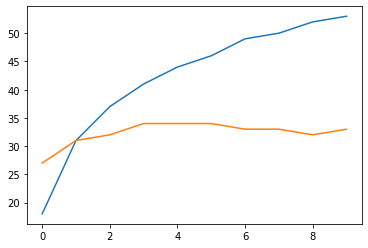

In [81]:
plt.plot([t/500 for t in train_correct], label="Train accuracy")
plt.plot([t/100 for t in test_correct], label="Test accuracy")

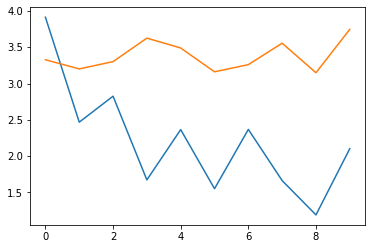

In [82]:
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")

In [89]:
test_all_data = DataLoader(test_data, batch_size=10_000, shuffle=False)
correct = 0
predictions = None

with torch.no_grad():

    for X_test, y_test in test_all_data:

        y_pred = model(X_test)

        loss = criterion(y_pred, y_test)

        predictions = torch.max(y_pred, dim=1)[1]
        correct += (predictions == y_test).sum()

print(f'Accuracy: {correct.item() / 100:.2f}%')

Accuracy: 33.48%


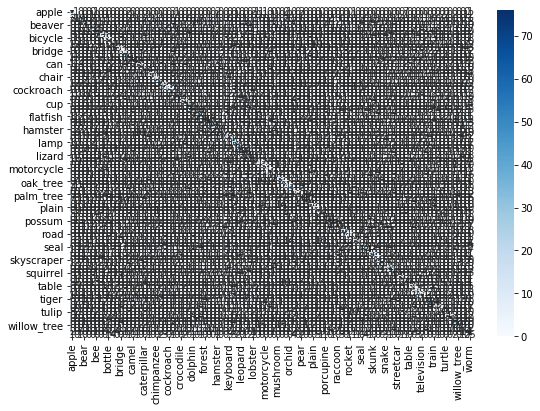

In [93]:
# Confusion matrix.
ar = confusion_matrix(y_test.view(-1), predictions.view(-1))
df = pd.DataFrame(ar, LABELS_LIST, LABELS_LIST)
plt.figure(figsize=(9, 6))
sb.heatmap(df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel("Ground Truth")
plt.show()